# SparkBeyond Data Challenge 
## Predict West Nile virus in mosquitos across the city of Chicago! - Aug 18, 2019

This is a 4-8 hour data challenge given by SparkBeyond to candidates from Insight DS.

### The Problem

The SparkBeyond data challenge consists of a 2015 Kaggle competition to predict the presence of the **West Nile Virus *(WNV)*** in mosquito traps in Chicago.

WNV is most commonly spread to people by the bite of an infected **mosquito**. The health of mosquito populations is driven largely by **weather**, where *hot and dry* weather increase mosquito populations and wet and cold weather dampen populatoin health. 

The goal of this challenge is to create a model to *predict the presence of the WNV* in trapped mosquitos around the city of Chicago. Important to this challenge is
- careful **feature engineering**
- determine feature **importance** for the model
- focus on **model interpretation**


### The Data

The data provided by the competition contain a train and test set, including the target variable (WnvPresent) and other features (date, location, trap ID, Lat, Lon, and number of mosquitos caught in the trap). 

Additional datasets include where spraying has occurred (date and location) and weather (). 

In [89]:
# import libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling as pp
import math

## Import the data 

In [6]:
spray = pd.read_csv('spray.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
weather = pd.read_csv('weather.csv')

In [9]:
train.head(1)
test.head(1)
spray.head(1)
weather.head(1)

Date                                            Address  \
0  2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   

              AddressNumberAndStreet  Latitude  Longitude  AddressAccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9   

   NumMosquitos  WnvPresent  
0             1           0

Id        Date                                            Address  \
0   1  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   

              AddressNumberAndStreet  Latitude  Longitude  AddressAccuracy  
0  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9

Date        Time   Latitude  Longitude
0  2011-08-29  6:56:58 PM  42.391623 -88.089163

Station        Date  Tmax  Tmin Tavg Depart  DewPoint WetBulb Heat Cool  \
0        1  2007-05-01    83    50   67     14        51      56    0    2   

   ... CodeSum Depth Water1 SnowFall PrecipTotal StnPressure SeaLevel  \
0  ...             0      M      0.0        0.00       29.10    29.82   

  ResultSpeed ResultDir  AvgSpeed  
0         1.7        27       9.2  

[1 rows x 22 columns]

## Useful Functions

In [90]:
# Calculate the relative humidity from the wet bulb (Tw) and dry bulb (Td or avg T)
def calcRelHum(Tw, Td):
    TwC = (Tw - 32.) * (5/9) 
    TdC = (Td - 32.) * (5/9)
    ed = 6.112*math.exp((17.502 * TdC) / (240.97 + TdC))
    ew = 6.112*math.exp((17.502 * TwC) / (240.97 + TwC))
    rh = (ew - .6687451 * (1 + .00115*TwC) * (TdC-TwC)) / (ed) * 100
    return(rh)



## Data cleaning and evaluation

In this section, we will take a look at the quality of the data

In [11]:
pp.ProfileReport(train)

In [12]:
pp.ProfileReport(weather)

### Create new weather df with only chosen and engineered features 

In [42]:
weather.head(5)

Station        Date  Tmax  Tmin Tavg Depart  DewPoint WetBulb Heat Cool  \
0        1  2007-05-01    83    50   67     14        51      56    0    2   
1        2  2007-05-01    84    52   68      M        51      57    0    3   
2        1  2007-05-02    59    42   51     -3        42      47   14    0   
3        2  2007-05-02    60    43   52      M        42      47   13    0   
4        1  2007-05-03    66    46   56      2        40      48    9    0   

   ... CodeSum Depth Water1 SnowFall PrecipTotal StnPressure SeaLevel  \
0  ...             0      M      0.0        0.00       29.10    29.82   
1  ...             M      M        M        0.00       29.18    29.82   
2  ...      BR     0      M      0.0        0.00       29.38    30.09   
3  ...   BR HZ     M      M        M        0.00       29.44    30.08   
4  ...             0      M      0.0        0.00       29.39    30.12   

  ResultSpeed ResultDir  AvgSpeed  
0         1.7        27       9.2  
1         2.7        25       9.6  
2        13.0         4      13.4  
3        13.3         2      13.4  
4        11.7         7      11.9  

[5 rows x 22 columns]

In [131]:
# Makea a copy of the weather data only from station 1
wth = weather[weather.Station == 1].copy()
wth = wth[wth.WetBulb != 'M']
wth.index = range(len(wth))

In [132]:
new = wth[['Date', 'Tmax', 'Tmin', 'Tavg', 'WetBulb', 'PrecipTotal']].copy()

In [133]:
# Calculate relative humidity and add to a new column 'Rel_Hum'
rh = []

for i in range(len(new)):
    rh.append(calcRelHum(float(new.WetBulb.iloc[i]), float(new.Tavg.iloc[i])))
    
new['Rel_Hum'] = rh

In [185]:
# Change T values in PrecipTot to 0.0
new['PrecipTotal'] = new['PrecipTotal'].replace(['  T'], 0.0)

# make sure column values are numeric
new[["Tmin", "Tmax", "Tavg", "WetBulb", "PrecipTotal"]] = new[["Tmin", "Tmax", "Tavg", "WetBulb", "PrecipTotal"]].apply(pd.to_numeric)

In [208]:
# Create a column with the avg avg T from 10-2 days before
priorT = list(new.Tavg[0:11].values)

for i in range(11,len(new)):
    priorT.append(new.Tavg[i-10:i-2].mean())
    
new['priorT'] = priorT

In [210]:
# Create a column with the avg avg Rel_Hum from 10-2 days before
priorRH = list(new.Rel_Hum[0:11].values)

for i in range(11,len(new)):
    priorRH.append(new.Rel_Hum[i-10:i-2].mean())
    
new['priorRH'] = priorRH

In [211]:
# Create a column with the avg avg Rel_Hum from 10-2 days before
priorP = list(new.PrecipTotal[0:11].values)

for i in range(11,len(new)):
    priorP.append(new.PrecipTotal[i-10:i-2].mean())
    
new['priorP'] = priorP

In [215]:
new = new.drop(columns=['WetBulb','Tavg'])

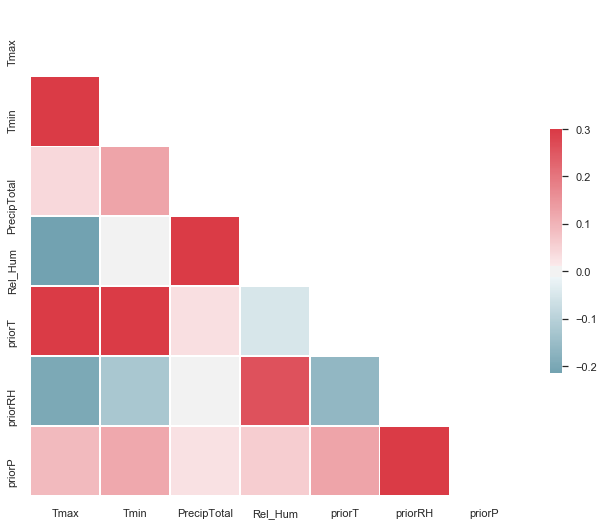

In [217]:
sns.set(style="white")


# Compute the correlation matrix
corr = new.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [218]:
weather_df = new.copy()